# Create MERA time series for comparison with measurements

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
import climag.climag as cplt

## Model results

In [24]:
ds = xr.open_mfdataset(
    os.path.join(
        "data", "ModVege", "MERA", "modvege_IE_MERA_FC3hr_3_day_*.nc"
    ),
    decode_coords="all",
    chunks="auto",
)

In [25]:
# limit to MERA time series
ds = ds.sel(time=slice("1981-01-01", "2019-08-31"))

In [26]:
# keep only growth
ds = ds.drop_vars([i for i in ds.data_vars if i != "gro"])

In [27]:
# # resample - yearly average
# ds_ = cplt.weighted_average(data=ds, averages="year")

In [28]:
# resample - weekly average
ds_ = ds.resample(time="W-MON").mean()

In [29]:
for var in ds_.data_vars:
    ds_[var].attrs = ds[var].attrs

In [30]:
ds_.rio.write_crs(cplt.projection_lambert_conformal, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 2018)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1981-01-05 ... 2019-09-02
    spatial_ref        int64 0
Data variables:
    gro                (time, y, x) float32 dask.array<chunksize=(1, 166, 158), meta=np.ndarray>
Attributes:
    creation_date:  2023-03-25 20:11:18.719312+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_MERA_FC3hr_3_day

## County boundaries

In [9]:
counties = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="OSi_OSNI_IE_Counties_2157",
)

## Land cover

In [11]:
# Corine land cover 2018
# pasture only - vectorised (done in QGIS)
pasture = gpd.read_file(
    os.path.join("data", "landcover", "clc-2018", "clc-2018-pasture.gpkg"),
    layer="dissolved",
)

## Zonal stats

In [ ]:
os.makedirs(os.path.join("data", "ModVege", "growth", "week"), exist_ok=True)

In [ ]:
# save each week as netCDF
for t in ds_["time"].values:
    ds_.sel(time=str(t)[:10]).to_netcdf(
        os.path.join(
            "data",
            "ModVege",
            "growth",
            "week",
            f"MERA_growth_{str(t)[:10]}.nc",
        )
    )

In [13]:
stats = {}

In [14]:
for t in ds_["time"].values:
    stats[str(t)[:10]] = gpd.GeoDataFrame.from_features(
        zonal_stats(
            vectors=counties.to_crs(cplt.projection_lambert_conformal),
            raster=os.path.join(
                "data",
                "ModVege",
                "growth",
                "week",
                f"MERA_growth_{str(t)[:10]}.nc",
            ),
            stats=["mean"],
            geojson_out=True,
            all_touched=True,
        )
    )
    stats[str(t)[:10]].drop(
        columns=["geometry", "PROVINCE", "CONTAE"], inplace=True
    )
    stats[str(t)[:10]]["time"] = str(t)[:10]

In [16]:
all_data = pd.concat([df for df in stats.values()], ignore_index=True)

In [20]:
all_data.head()

,COUNTY,mean,time
0,DONEGAL,0.143106,1981-01-05
1,LIMERICK,0.367039,1981-01-05
2,KILDARE,0.196928,1981-01-05
3,WATERFORD,0.529810,1981-01-05
4,DUBLIN,0.320577,1981-01-05


In [19]:
all_data.to_csv(
    os.path.join("data", "ModVege", "growth", "MERA_growth_week_all.csv"),
    index=False,
)

## Zonal stats - only for pastures

In [32]:
os.makedirs(
    os.path.join("data", "ModVege", "growth", "week_pasture"), exist_ok=True
)

In [33]:
# mask out non-pasture areas
ds_ = ds_.rio.clip(
    pasture["geometry"].to_crs(cplt.projection_lambert_conformal),
    all_touched=True,
)

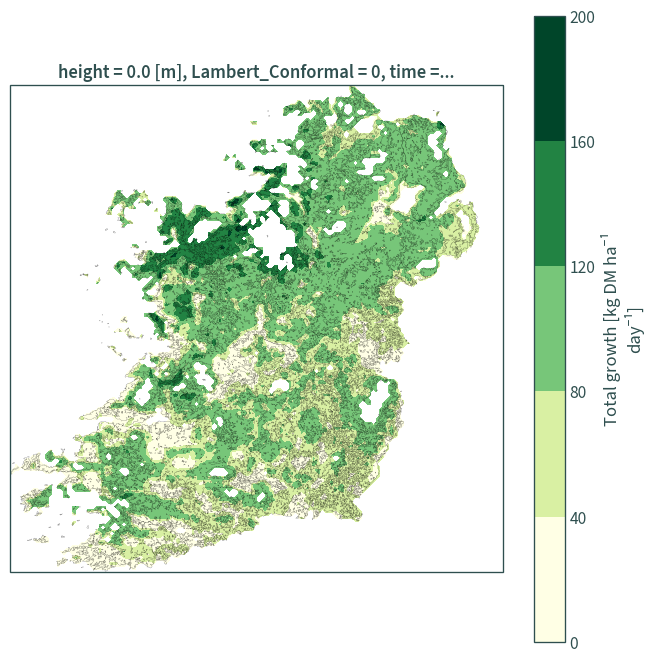

In [52]:
plt.figure(figsize=(7, 7))
axs = plt.axes(projection=cplt.projection_lambert_conformal)
ds_.isel(time=30)["gro"].plot.contourf(cmap="YlGn", ax=axs)
pasture.to_crs(cplt.projection_lambert_conformal).boundary.plot(
    linewidth=0.1, ax=axs, color="black"
)
plt.tight_layout()
plt.show()

In [53]:
# save each week as netCDF
for t in ds_["time"].values:
    ds_.sel(time=str(t)[:10]).to_netcdf(
        os.path.join(
            "data",
            "ModVege",
            "growth",
            "week_pasture",
            f"MERA_growth_{str(t)[:10]}.nc",
        )
    )

In [54]:
stats = {}

In [55]:
for t in ds_["time"].values:
    stats[str(t)[:10]] = gpd.GeoDataFrame.from_features(
        zonal_stats(
            vectors=counties.to_crs(cplt.projection_lambert_conformal),
            raster=os.path.join(
                "data",
                "ModVege",
                "growth",
                "week_pasture",
                f"MERA_growth_{str(t)[:10]}.nc",
            ),
            stats=["mean"],
            geojson_out=True,
            all_touched=True,
        )
    )
    stats[str(t)[:10]].drop(
        columns=["geometry", "PROVINCE", "CONTAE"], inplace=True
    )
    stats[str(t)[:10]]["time"] = str(t)[:10]

In [56]:
all_data = pd.concat([df for df in stats.values()], ignore_index=True)

In [57]:
all_data.head()

,COUNTY,mean,time
0,DONEGAL,0.175074,1981-01-05
1,LIMERICK,0.376006,1981-01-05
2,KILDARE,0.197097,1981-01-05
3,WATERFORD,0.549799,1981-01-05
4,DUBLIN,0.226976,1981-01-05


In [58]:
all_data.shape

(64576, 3)

In [59]:
all_data.to_csv(
    os.path.join("data", "ModVege", "growth", "MERA_growth_week_pasture.csv"),
    index=False,
)